In [1]:
# !git clone https://www.github.com/yankeesong/MLE.git
# !pip install d2l==1.0.0b0
# !pip install mxnet
from google.colab import files
import sys, warnings
sys.path.insert(0,'/content/MLE')
from dl_helpers_Yanke import *

# CNN

In [ ]:
# Fashion Dataset
class FashionMNIST(d2l.DataModule):
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)
@d2l.add_to_class(FashionMNIST)
def text_labels(self, indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]
@d2l.add_to_class(FashionMNIST)
def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=self.num_workers)
@d2l.add_to_class(FashionMNIST)
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)

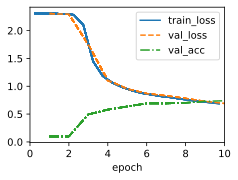

In [ ]:
# LeNet
class LeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

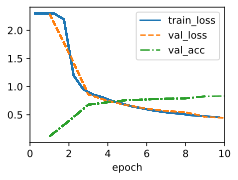

In [ ]:
# AlexNet
class AlexNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=11, stride=4, padding=1),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(384, kernel_size=3, padding=1), nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(p=0.5),
            nn.LazyLinear(4096), nn.ReLU(),nn.Dropout(p=0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)
model = AlexNet(lr=0.01)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)

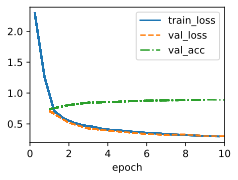

In [ ]:
# VGG
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

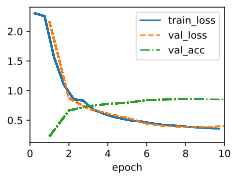

In [ ]:
# NiN
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU())
class NiN(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=11, strides=4, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=5, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())
        self.net.apply(d2l.init_cnn)
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

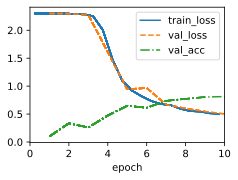

In [ ]:
# Inception and LeNet
class Inception(nn.Module):
    # `c1`--`c4` are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)
class GoogleNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b2(self):
      return nn.Sequential(
          nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
          nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
          nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b3(self):
      return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                          Inception(128, (128, 192), (32, 96), 64),
                          nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b4(self):
      return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                          Inception(160, (112, 224), (24, 64), 64),
                          Inception(128, (128, 256), (24, 64), 64),
                          Inception(112, (144, 288), (32, 64), 64),
                          Inception(256, (160, 320), (32, 128), 128),
                          nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def b5(self):
      return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                          Inception(384, (192, 384), (48, 128), 128),
                          nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())
    def __init__(self, lr=0.1, num_classes=10):
      super(GoogleNet, self).__init__()
      self.save_hyperparameters()
      self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                              self.b5(), nn.LazyLinear(num_classes))
      self.net.apply(d2l.init_cnn)
model = GoogleNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

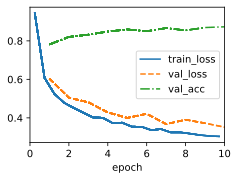

In [ ]:
# LeNet with Batch Normalization
class BNLeNet(d2l.Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(),
            nn.Sigmoid(), nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(), nn.LazyLinear(120), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(84), nn.LazyBatchNorm1d(),
            nn.Sigmoid(), nn.LazyLinear(num_classes))
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = BNLeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

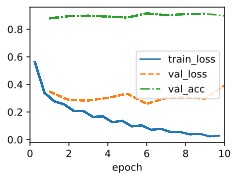

In [ ]:
# ResNet
class Residual(nn.Module):
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def block(self, num_residuals, num_channels, first_block=False):
      blk = []
      for i in range(num_residuals):
          if i == 0 and not first_block:
              blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
          else:
              blk.append(Residual(num_channels))
      return nn.Sequential(*blk)
    def __init__(self, arch, lr=0.1, num_classes=10):
      super(ResNet, self).__init__()
      self.save_hyperparameters()
      self.net = nn.Sequential(self.b1())
      for i, b in enumerate(arch):
          self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
      self.net.add_module('last', nn.Sequential(
          nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
          nn.LazyLinear(num_classes)))
      self.net.apply(d2l.init_cnn)
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

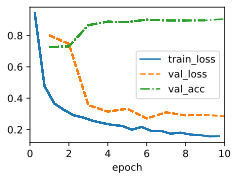

In [ ]:
# DenseNet
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X
class DenseNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def __init__(self, num_channels=64, growth_rate=32, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
      super(DenseNet, self).__init__()
      self.save_hyperparameters()
      self.net = nn.Sequential(self.b1())
      for i, num_convs in enumerate(arch):
          self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                            growth_rate))
          # The number of output channels in the previous dense block
          num_channels += num_convs * growth_rate
          # A transition layer that halves the number of channels is added
          # between the dense blocks
          if i != len(arch) - 1:
              num_channels //= 2
              self.net.add_module(f'tran_blk{i+1}', transition_block(
                  num_channels))
      self.net.add_module('last', nn.Sequential(
          nn.LazyBatchNorm2d(), nn.ReLU(),
          nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
          nn.LazyLinear(num_classes)))
      self.net.apply(d2l.init_cnn)
model = DenseNet(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
trainer.fit(model, data)

# RNN

'it has i but how the time '

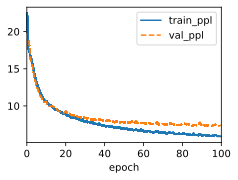

In [ ]:
# RNN
class RNN(d2l.Module):
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

class RNNLM(d2l.Classifier):
    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()
    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)
    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)
    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=True)
        return l
    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot('ppl', torch.exp(l), train=False)
    def one_hot(self, X):
        # Output shape: (num_steps, batch_size, vocab_size)
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)
    def forward(self, X, state=None):
        embs = self.one_hot(X)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)
    def predict(self, prefix, num_preds, vocab, device=None):
        state, outputs = None, [vocab[prefix[0]]]
        for i in range(len(prefix) + num_preds - 1):
            X = torch.tensor([[outputs[-1]]], device=device)
            embs = self.one_hot(X)
            rnn_outputs, state = self.rnn(embs, state)
            if i < len(prefix) - 1:  # Warm-up period
                outputs.append(vocab[prefix[i + 1]])
            else:  # Predict `num_preds` steps
                Y = self.output_layer(rnn_outputs)
                outputs.append(int(Y.argmax(axis=2).reshape(1)))
        return ''.join([vocab.idx_to_token[i] for i in outputs])

data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has the time tree time '

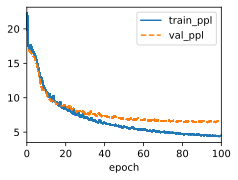

In [ ]:
# LSTM
class LSTM(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, inputs, H_C=None):
        return self.rnn(inputs, H_C)

lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)
model.predict('it has', 20, data.vocab, d2l.try_gpu())

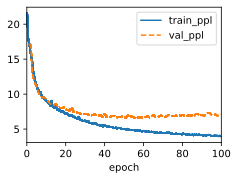

In [ ]:
# GRU
class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has of the time travell'

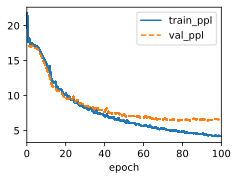

In [ ]:
# Deep RNN using GRU
class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens, num_layers,
                          dropout=dropout)
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=2)
trainer.fit(model, data)
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it hasasasasasasasasasasas'

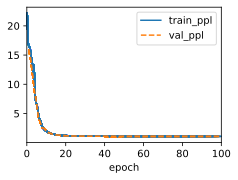

In [ ]:
# Bidirectional RNN using GRU
class BiGRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens, bidirectional=True)
        self.num_hiddens *= 2
bigru = BiGRU(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(bigru, vocab_size=len(data.vocab), lr=2)
trainer.fit(model, data)
model.predict('it has', 20, data.vocab, d2l.try_gpu())

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['nous', '<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', 'moi', 'qui', "l'ai", 'fait', '.'], bleu,0.583


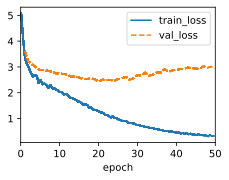

In [ ]:
# Encoder-Decoder
class Encoder(nn.Module):
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self):
        super().__init__()
    # Later there can be additional arguments (e.g., length excluding padding)
    def forward(self, X, *args):
        raise NotImplementedError
class Decoder(nn.Module):
    """The base decoder interface for the encoder-decoder architecture."""
    def __init__(self):
        super().__init__()
    # Later there can be additional arguments (e.g., length excluding padding)
    def init_state(self, enc_outputs, *args):
        raise NotImplementedError
    def forward(self, X, state):
        raise NotImplementedError
class EncoderDecoder(d2l.Classifier):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        # Return decoder output only
        return self.decoder(dec_X, dec_state)[0]

def init_seq2seq(module):
    """Initialize weights for Seq2Seq."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])
class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)
    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        output, state = self.rnn(embs)
        # output shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return output, state
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)
    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]
    def forward(self, X, enc_state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        # context shape: (batch_size, num_hiddens)
        context = enc_state[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, state = self.rnn(embs_and_context, enc_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state
    def predict_step(self, batch, device, num_steps,
                 save_attention_weights=False):
      batch = [a.to(device) for a in batch]
      src, tgt, src_valid_len, _ = batch
      enc_outputs = self.encoder(src, src_valid_len)
      dec_state = self.decoder.init_state(enc_outputs, src_valid_len)
      outputs, attention_weights = [tgt[:, 0].unsqueeze(1), ], []
      for _ in range(num_steps):
          Y, dec_state = self.decoder(outputs[-1], dec_state)
          outputs.append(Y.argmax(2))
          # Save attention weights (to be covered later)
          if save_attention_weights:
              attention_weights.append(self.decoder.attention_weights)
      return torch.cat(outputs[1:], 1), attention_weights
class Seq2Seq(d2l.EncoderDecoder):
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    def loss(self, Y_hat, Y):
        l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
        return (l * mask).sum() / mask.sum()
def bleu(pred_seq, label_seq, k):
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score
    
# Training
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.001)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

# Testing
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

# Transformers

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['<unk>', 'calme', '.'], bleu,0.492
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


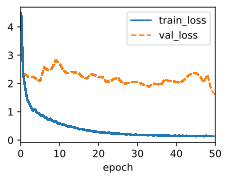

In [ ]:
# Masked softmax
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

# Attention scoring functions
class AdditiveAttention(nn.Module):
    """Additive attention."""
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of queries: (batch_size, no. of
        # queries, 1, num_hiddens) and shape of keys: (batch_size, 1, no. of
        # key-value pairs, num_hiddens). Sum them up with broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of self.w_v, so we remove the last
        # one-dimensional entry from the shape. Shape of scores: (batch_size,
        # no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of values: (batch_size, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout, num_heads=None):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.num_heads = num_heads  # To be covered later

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None,
                window_mask=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        if window_mask is not None:  # To be covered later
            num_windows = window_mask.shape[0]
            n, num_queries, num_kv_pairs = scores.shape
            # Shape of window_mask: (num_windows, no. of queries,
            # no. of key-value pairs)
            scores = scores.reshape((n // (num_windows * self.num_heads), num_windows, self.
    num_heads, num_queries, num_kv_pairs)) + window_mask.unsqueeze(1).unsqueeze(0)
            scores = scores.reshape((n, num_queries, num_kv_pairs))
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

# Attention Heads
class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)
class PositionWiseFFN(nn.Module):
    """Positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))
class MultiHeadAttention(d2l.Module):
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout, num_heads)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)
    def forward(self, queries, keys, values, valid_lens, window_mask=None):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs,
        # num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))
        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)
        # Shape of output: (batch_size * num_heads, no. of queries,
        # num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens,
                                window_mask)
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)
    def transpose_qkv(self, X):
        """Transposition for parallel computation of multiple attention heads."""
        # Shape of input X: (batch_size, no. of queries or key-value pairs,
        # num_hiddens). Shape of output X: (batch_size, no. of queries or
        # key-value pairs, num_heads, num_hiddens / num_heads)
        X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
        # Shape of output X: (batch_size, num_heads, no. of queries or key-value
        # pairs, num_hiddens / num_heads)
        X = X.permute(0, 2, 1, 3)
        # Shape of output: (batch_size * num_heads, no. of queries or key-value
        # pairs, num_hiddens / num_heads)
        return X.reshape(-1, X.shape[2], X.shape[3])
    def transpose_output(self, X):
        """Reverse the operation of transpose_qkv."""
        X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
        X = X.permute(0, 2, 1, 3)
        return X.reshape(X.shape[0], X.shape[1], -1)
class AddNorm(nn.Module):
    """Residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

# Attention Networks
class AttentionDecoder(d2l.Decoder):
    """The base attention-based decoder interface."""
    def __init__(self):
        super().__init__()
    @property
    def attention_weights(self):
        raise NotImplementedError
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)
    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of query: (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape x as (1, batch_size, embed_size + num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]
    @property
    def attention_weights(self):
        return self._attention_weights

# Transformers
class TransformerEncoderBlock(nn.Module):
    """Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))
class TransformerEncoder(d2l.Encoder):
    """Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))
    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)
    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)
    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

# Training
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.001)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

# Translation
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

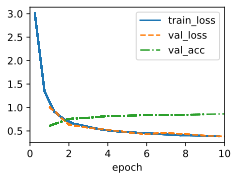

In [ ]:
# Vision Transformer
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (
            img_size[1] // patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size,
                                  stride=patch_size)
    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).flatten(2).transpose(1, 2)
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(
            self.dense1(x)))))
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.ln2 = nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        X = self.ln1(X)
        return X + self.mlp(self.ln2(
            X + self.attention(X, X, X, valid_lens)))
class ViT(d2l.Classifier):
    """Vision transformer."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(
            img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(
                num_hiddens, num_hiddens, mlp_num_hiddens,
                num_heads, blk_dropout, use_bias))
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens),
                                  nn.Linear(num_hiddens, num_classes))

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        return self.head(X[:, 0])

img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
trainer.fit(model, data)

# GAN

## Vanilla GAN

loss_D 0.693, loss_G 0.694, 2191.3 examples/sec


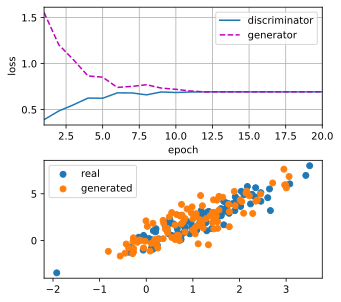

In [3]:
## Vanilla GAN

# Fake data
X = torch.normal(0.0, 1, (1000, 2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])
data = torch.matmul(X, A) + b

batch_size = 8
data_iter = d2l.load_array((data,), batch_size)

# Generator
net_G = nn.Sequential(nn.Linear(2, 2))

# Discriminator
net_D = nn.Sequential(
    nn.Linear(2, 5), nn.Tanh(),
    nn.Linear(5, 3), nn.Tanh(),
    nn.Linear(3, 1))

# Trainer
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)
    trainer_D.zero_grad()
    real_Y = net_D(X)
    fake_X = net_G(Z)
    # Do not need to compute gradient for `net_G`, detach it from
    # computing gradients.
    fake_Y = net_D(fake_X.detach())
    loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) +
              loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2
    loss_D.backward()
    trainer_D.step()
    return loss_D

def update_G(Z, net_D, net_G, loss, trainer_G):
    """Update generator."""
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,), device=Z.device)
    trainer_G.zero_grad()
    # We could reuse `fake_X` from `update_D` to save computation
    fake_X = net_G(Z)
    # Recomputing `fake_Y` is needed since `net_D` is changed
    fake_Y = net_D(fake_X)
    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
    loss_G.backward()
    trainer_G.step()
    return loss_G

def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(num_epochs):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for (X,) in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim))
            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),
                       update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Visualize generated examples
        Z = torch.normal(0, 1, size=(100, latent_dim))
        fake_X = net_G(Z).detach().numpy()
        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(['real', 'generated'])
        # Show the losses
        loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
        animator.add(epoch + 1, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec')
    
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G,
      latent_dim, data[:100].detach().numpy())

## Deep Convolutional GAN

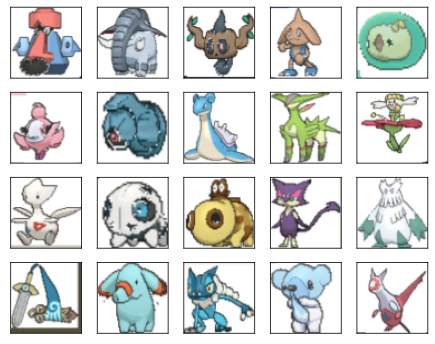

In [7]:
# Pokemon dataset
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')
data_dir = d2l.download_extract('pokemon')
pokemon = torchvision.datasets.ImageFolder(data_dir)

batch_size = 256
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])
pokemon.transform = transformer
data_iter = torch.utils.data.DataLoader(
    pokemon, batch_size=batch_size,
    shuffle=True, num_workers=d2l.get_dataloader_workers())

warnings.filterwarnings('ignore')
d2l.set_figsize((4, 4))
for X, y in data_iter:
    imgs = X[:20,:,:,:].permute(0, 2, 3, 1)/2+0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break

loss_D 0.106, loss_G 7.249, 656.6 examples/sec on cuda:0


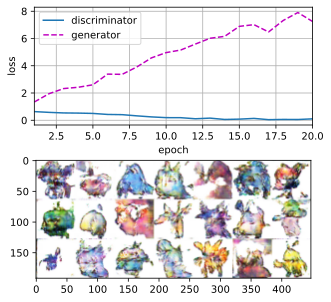

In [8]:
# Generator
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                 padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

n_G = 64
net_G = nn.Sequential(
    G_block(in_channels=100, out_channels=n_G*8,
            strides=1, padding=0),                  # Output: (64 * 8, 4, 4)
    G_block(in_channels=n_G*8, out_channels=n_G*4), # Output: (64 * 4, 8, 8)
    G_block(in_channels=n_G*4, out_channels=n_G*2), # Output: (64 * 2, 16, 16)
    G_block(in_channels=n_G*2, out_channels=n_G),   # Output: (64, 32, 32)
    nn.ConvTranspose2d(in_channels=n_G, out_channels=3,
                       kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh())

# Discriminator
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size,
                                strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

n_D = 64
net_D = nn.Sequential(
    D_block(n_D),  # Output: (64, 32, 32)
    D_block(in_channels=n_D, out_channels=n_D*2),  # Output: (64 * 2, 16, 16)
    D_block(in_channels=n_D*2, out_channels=n_D*4),  # Output: (64 * 4, 8, 8)
    D_block(in_channels=n_D*4, out_channels=n_D*8),  # Output: (64 * 8, 4, 4)
    nn.Conv2d(in_channels=n_D*8, out_channels=1,
              kernel_size=4, bias=False))  # Output: (1, 1, 1)

# Trainer
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    net_D, net_G = net_D.to(device), net_G.to(device)
    trainer_hp = {'lr': lr, 'betas': [0.5,0.999]}
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                       d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Show generated examples
        Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
        imgs = torch.cat(
            [torch.cat([
                fake_x[i * 7 + j].cpu().detach() for j in range(7)], dim=1)
             for i in range(len(fake_x)//7)], dim=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')
    
latent_dim, lr, num_epochs = 100, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

# Recommender Systems

In [16]:
# MovieLens dataset
d2l.DATA_HUB['ml-100k'] = (
    'https://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

# Split train tes
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

def split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(
        data, num_users, num_items, split_mode, test_ratio)
    train_u, train_i, train_r, _ = load_data_ml100k(
        train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(
        test_data, num_users, num_items, feedback)
    train_set = gluon.data.ArrayDataset(
        np.array(train_u), np.array(train_i), np.array(train_r))
    test_set = gluon.data.ArrayDataset(
        np.array(test_u), np.array(test_i), np.array(test_r))
    train_iter = gluon.data.DataLoader(
        train_set, shuffle=True, last_batch='rollover',
        batch_size=batch_size)
    test_iter = gluon.data.DataLoader(
        test_set, batch_size=batch_size)
    return num_users, num_items, train_iter, test_iter

## Matrix Factorization

In [18]:
# Matrix Factorization Model
import mxnet as mx
from mxnet import autograd, gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l
npx.set_np()

class MF(nn.Block):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(MF, self).__init__(**kwargs)
        self.P = nn.Embedding(input_dim=num_users, output_dim=num_factors)
        self.Q = nn.Embedding(input_dim=num_items, output_dim=num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        outputs = (P_u * Q_i).sum(axis=1) + np.squeeze(b_u) + np.squeeze(b_i)
        return outputs.flatten()

# Evaluation Metric
def evaluator(net, test_iter, devices):
    rmse = mx.metric.RMSE()  # Get the RMSE
    rmse_list = []
    for idx, (users, items, ratings) in enumerate(test_iter):
        u = gluon.utils.split_and_load(users, devices, even_split=False)
        i = gluon.utils.split_and_load(items, devices, even_split=False)
        r_ui = gluon.utils.split_and_load(ratings, devices, even_split=False)
        r_hat = [net(u, i) for u, i in zip(u, i)]
        rmse.update(labels=r_ui, preds=r_hat)
        rmse_list.append(rmse.get()[1])
    return float(np.mean(np.array(rmse_list)))

def train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                        devices=d2l.try_all_gpus(), evaluator=None,
                        **kwargs):
    timer = d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 2],
                            legend=['train loss', 'test RMSE'])
    for epoch in range(num_epochs):
        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            timer.start()
            input_data = []
            values = values if isinstance(values, list) else [values]
            for v in values:
                input_data.append(gluon.utils.split_and_load(v, devices, even_split=False))
            train_feat = input_data[:-1] if len(values) > 1 else input_data
            train_label = input_data[-1]
            with autograd.record():
                preds = [net(*t) for t in zip(*train_feat)]
                ls = [loss(p, s) for p, s in zip(preds, train_label)]
            [l.backward() for l in ls]
            l += sum([l.asnumpy() for l in ls]).mean() / len(devices)
            trainer.step(values[0].shape[0])
            metric.add(l, values[0].shape[0], values[0].size)
            timer.stop()
        if len(kwargs) > 0:  # It will be used in section AutoRec
            test_rmse = evaluator(net, test_iter, kwargs['inter_mat'],
                                  devices)
        else:
            test_rmse = evaluator(net, test_iter, devices)
        train_l = l / (i + 1)
        animator.add(epoch + 1, (train_l, test_rmse))
    print(f'train loss {metric[0] / metric[1]:.3f}, '
          f'test RMSE {test_rmse:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')

# Trainer
devices = d2l.try_all_gpus()
num_users, num_items, train_iter, test_iter = d2l.split_and_load_ml100k(
    test_ratio=0.1, batch_size=512)
net = MF(30, num_users, num_items)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.002, 20, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})
train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                    devices, evaluator)

## AutoRec

In [21]:
class AutoRec(nn.Block):
    def __init__(self, num_hidden, num_users, dropout=0.05):
        super(AutoRec, self).__init__()
        self.encoder = nn.Dense(num_hidden, activation='sigmoid',
                                use_bias=True)
        self.decoder = nn.Dense(num_users, use_bias=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        hidden = self.dropout(self.encoder(input))
        pred = self.decoder(hidden)
        if autograd.is_training():  # Mask the gradient during training
            return pred * np.sign(input)
        else:
            return pred

def evaluator(network, inter_matrix, test_data, devices):
    scores = []
    for values in inter_matrix:
        feat = gluon.utils.split_and_load(values, devices, even_split=False)
        scores.extend([network(i).asnumpy() for i in feat])
    recons = np.array([item for sublist in scores for item in sublist])
    # Calculate the test RMSE
    rmse = np.sqrt(np.sum(np.square(test_data - np.sign(test_data) * recons))
                   / np.sum(np.sign(test_data)))
    return float(rmse)

devices = d2l.try_all_gpus()
# Load the MovieLens 100K dataset
df, num_users, num_items = d2l.read_data_ml100k()
train_data, test_data = d2l.split_data_ml100k(df, num_users, num_items)
_, _, _, train_inter_mat = d2l.load_data_ml100k(train_data, num_users,
                                                num_items)
_, _, _, test_inter_mat = d2l.load_data_ml100k(test_data, num_users,
                                               num_items)
train_iter = gluon.data.DataLoader(train_inter_mat, shuffle=True,
                                   last_batch="rollover", batch_size=256,
                                   num_workers=d2l.get_dataloader_workers())
test_iter = gluon.data.DataLoader(np.array(test_inter_mat), shuffle=False,
                                  last_batch="keep", batch_size=1024,
                                  num_workers=d2l.get_dataloader_workers())
# Model initialization, training, and evaluation
net = AutoRec(500, num_users)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.002, 25, 1e-5, 'adam'
loss = gluon.loss.L2Loss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})
d2l.train_recsys_rating(net, train_iter, test_iter, loss, trainer, num_epochs,
                        devices, evaluator, inter_mat=test_inter_mat)

## NeuMF

In [ ]:
class NeuMF(nn.Block):
    def __init__(self, num_factors, num_users, num_items, nums_hiddens,
                 **kwargs):
        super(NeuMF, self).__init__(**kwargs)
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.U = nn.Embedding(num_users, num_factors)
        self.V = nn.Embedding(num_items, num_factors)
        self.mlp = nn.Sequential()
        for num_hiddens in nums_hiddens:
            self.mlp.add(nn.Dense(num_hiddens, activation='relu',
                                  use_bias=True))
        self.prediction_layer = nn.Dense(1, activation='sigmoid', use_bias=False)

    def forward(self, user_id, item_id):
        p_mf = self.P(user_id)
        q_mf = self.Q(item_id)
        gmf = p_mf * q_mf
        p_mlp = self.U(user_id)
        q_mlp = self.V(item_id)
        mlp = self.mlp(np.concatenate([p_mlp, q_mlp], axis=1))
        con_res = np.concatenate([gmf, mlp], axis=1)
        return self.prediction_layer(con_res)

# DS with negative sampling
class PRDataset(gluon.data.Dataset):
    def __init__(self, users, items, candidates, num_items):
        self.users = users
        self.items = items
        self.cand = candidates
        self.all = set([i for i in range(num_items)])

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        neg_items = list(self.all - set(self.cand[int(self.users[idx])]))
        indices = random.randint(0, len(neg_items) - 1)
        return self.users[idx], self.items[idx], neg_items[indices]

# Evaluation
def hit_and_auc(rankedlist, test_matrix, k):
    hits_k = [(idx, val) for idx, val in enumerate(rankedlist[:k])
              if val in set(test_matrix)]
    hits_all = [(idx, val) for idx, val in enumerate(rankedlist)
                if val in set(test_matrix)]
    max = len(rankedlist) - 1
    auc = 1.0 * (max - hits_all[0][0]) / max if len(hits_all) > 0 else 0
    return len(hits_k), auc

def evaluate_ranking(net, test_input, seq, candidates, num_users, num_items,
                     devices):
    ranked_list, ranked_items, hit_rate, auc = {}, {}, [], []
    all_items = set([i for i in range(num_users)])
    for u in range(num_users):
        neg_items = list(all_items - set(candidates[int(u)]))
        user_ids, item_ids, x, scores = [], [], [], []
        [item_ids.append(i) for i in neg_items]
        [user_ids.append(u) for _ in neg_items]
        x.extend([np.array(user_ids)])
        if seq is not None:
            x.append(seq[user_ids, :])
        x.extend([np.array(item_ids)])
        test_data_iter = gluon.data.DataLoader(
            gluon.data.ArrayDataset(*x), shuffle=False, last_batch="keep",
            batch_size=1024)
        for index, values in enumerate(test_data_iter):
            x = [gluon.utils.split_and_load(v, devices, even_split=False)
                 for v in values]
            scores.extend([list(net(*t).asnumpy()) for t in zip(*x)])
        scores = [item for sublist in scores for item in sublist]
        item_scores = list(zip(item_ids, scores))
        ranked_list[u] = sorted(item_scores, key=lambda t: t[1], reverse=True)
        ranked_items[u] = [r[0] for r in ranked_list[u]]
        temp = hit_and_auc(ranked_items[u], test_input[u], 50)
        hit_rate.append(temp[0])
        auc.append(temp[1])
    return np.mean(np.array(hit_rate)), np.mean(np.array(auc))

# Load data
batch_size = 1024
df, num_users, num_items = d2l.read_data_ml100k()
train_data, test_data = d2l.split_data_ml100k(df, num_users, num_items,
                                              'seq-aware')
users_train, items_train, ratings_train, candidates = d2l.load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
users_test, items_test, ratings_test, test_iter = d2l.load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit")
train_iter = gluon.data.DataLoader(
    PRDataset(users_train, items_train, candidates, num_items ), batch_size,
    True, last_batch="rollover", num_workers=d2l.get_dataloader_workers())

# Training
def train_ranking(net, train_iter, test_iter, loss, trainer, test_seq_iter,
                  num_users, num_items, num_epochs, devices, evaluator,
                  candidates, eval_step=1):
    timer, hit_rate, auc = d2l.Timer(), 0, 0
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['test hit rate', 'test AUC'])
    for epoch in range(num_epochs):
        metric, l = d2l.Accumulator(3), 0.
        for i, values in enumerate(train_iter):
            input_data = []
            for v in values:
                input_data.append(gluon.utils.split_and_load(v, devices))
            with autograd.record():
                p_pos = [net(*t) for t in zip(*input_data[:-1])]
                p_neg = [net(*t) for t in zip(*input_data[:-2],
                                              input_data[-1])]
                ls = [loss(p, n) for p, n in zip(p_pos, p_neg)]
            [l.backward(retain_graph=False) for l in ls]
            l += sum([l.asnumpy() for l in ls]).mean()/len(devices)
            trainer.step(values[0].shape[0])
            metric.add(l, values[0].shape[0], values[0].size)
            timer.stop()
        with autograd.predict_mode():
            if (epoch + 1) % eval_step == 0:
                hit_rate, auc = evaluator(net, test_iter, test_seq_iter,
                                          candidates, num_users, num_items,
                                          devices)
                animator.add(epoch + 1, (hit_rate, auc))
    print(f'train loss {metric[0] / metric[1]:.3f}, '
          f'test hit rate {float(hit_rate):.3f}, test AUC {float(auc):.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(devices)}')
    
devices = d2l.try_all_gpus()
net = NeuMF(10, num_users, num_items, nums_hiddens=[10, 10, 10])
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))

lr, num_epochs, wd, optimizer = 0.01, 10, 1e-5, 'adam'
loss = d2l.BPRLoss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})
train_ranking(net, train_iter, test_iter, loss, trainer, None, num_users,
              num_items, num_epochs, devices, evaluate_ranking, candidates)

## Caser

In [ ]:
class Caser(nn.Block):
    def __init__(self, num_factors, num_users, num_items, L=5, d=16,
                 d_prime=4, drop_ratio=0.05, **kwargs):
        super(Caser, self).__init__(**kwargs)
        self.P = nn.Embedding(num_users, num_factors)
        self.Q = nn.Embedding(num_items, num_factors)
        self.d_prime, self.d = d_prime, d
        # Vertical convolution layer
        self.conv_v = nn.Conv2D(d_prime, (L, 1), in_channels=1)
        # Horizontal convolution layer
        h = [i + 1 for i in range(L)]
        self.conv_h, self.max_pool = nn.Sequential(), nn.Sequential()
        for i in h:
            self.conv_h.add(nn.Conv2D(d, (i, num_factors), in_channels=1))
            self.max_pool.add(nn.MaxPool1D(L - i + 1))
        # Fully connected layer
        self.fc1_dim_v, self.fc1_dim_h = d_prime * num_factors, d * len(h)
        self.fc = nn.Dense(in_units=d_prime * num_factors + d * L,
                           activation='relu', units=num_factors)
        self.Q_prime = nn.Embedding(num_items, num_factors * 2)
        self.b = nn.Embedding(num_items, 1)
        self.dropout = nn.Dropout(drop_ratio)

    def forward(self, user_id, seq, item_id):
        item_embs = np.expand_dims(self.Q(seq), 1)
        user_emb = self.P(user_id)
        out, out_h, out_v, out_hs = None, None, None, []
        if self.d_prime:
            out_v = self.conv_v(item_embs)
            out_v = out_v.reshape(out_v.shape[0], self.fc1_dim_v)
        if self.d:
            for conv, maxp in zip(self.conv_h, self.max_pool):
                conv_out = np.squeeze(npx.relu(conv(item_embs)), axis=3)
                t = maxp(conv_out)
                pool_out = np.squeeze(t, axis=2)
                out_hs.append(pool_out)
            out_h = np.concatenate(out_hs, axis=1)
        out = np.concatenate([out_v, out_h], axis=1)
        z = self.fc(self.dropout(out))
        x = np.concatenate([z, user_emb], axis=1)
        q_prime_i = np.squeeze(self.Q_prime(item_id))
        b = np.squeeze(self.b(item_id))
        res = (x * q_prime_i).sum(1) + b
        return res

class SeqDataset(gluon.data.Dataset):
    def __init__(self, user_ids, item_ids, L, num_users, num_items,
                 candidates):
        user_ids, item_ids = np.array(user_ids), np.array(item_ids)
        sort_idx = np.array(sorted(range(len(user_ids)),
                                   key=lambda k: user_ids[k]))
        u_ids, i_ids = user_ids[sort_idx], item_ids[sort_idx]
        temp, u_ids, self.cand = {}, u_ids.asnumpy(), candidates
        self.all_items = set([i for i in range(num_items)])
        [temp.setdefault(u_ids[i], []).append(i) for i, _ in enumerate(u_ids)]
        temp = sorted(temp.items(), key=lambda x: x[0])
        u_ids = np.array([i[0] for i in temp])
        idx = np.array([i[1][0] for i in temp])
        self.ns = ns = int(sum([c - L if c >= L + 1 else 1 for c
                                in np.array([len(i[1]) for i in temp])]))
        self.seq_items = np.zeros((ns, L))
        self.seq_users = np.zeros(ns, dtype='int32')
        self.seq_tgt = np.zeros((ns, 1))
        self.test_seq = np.zeros((num_users, L))
        test_users, _uid = np.empty(num_users), None
        for i, (uid, i_seq) in enumerate(self._seq(u_ids, i_ids, idx, L + 1)):
            if uid != _uid:
                self.test_seq[uid][:] = i_seq[-L:]
                test_users[uid], _uid = uid, uid
            self.seq_tgt[i][:] = i_seq[-1:]
            self.seq_items[i][:], self.seq_users[i] = i_seq[:L], uid

    def _win(self, tensor, window_size, step_size=1):
        if len(tensor) - window_size >= 0:
            for i in range(len(tensor), 0, - step_size):
                if i - window_size >= 0:
                    yield tensor[i - window_size:i]
                else:
                    break
        else:
            yield tensor

    def _seq(self, u_ids, i_ids, idx, max_len):
        for i in range(len(idx)):
            stop_idx = None if i >= len(idx) - 1 else int(idx[i + 1])
            for s in self._win(i_ids[int(idx[i]):stop_idx], max_len):
                yield (int(u_ids[i]), s)

    def __len__(self):
        return self.ns

    def __getitem__(self, idx):
        neg = list(self.all_items - set(self.cand[int(self.seq_users[idx])]))
        i = random.randint(0, len(neg) - 1)
        return (self.seq_users[idx], self.seq_items[idx], self.seq_tgt[idx],
                neg[i])
        
TARGET_NUM, L, batch_size = 1, 5, 4096
df, num_users, num_items = d2l.read_data_ml100k()
train_data, test_data = d2l.split_data_ml100k(df, num_users, num_items,
                                              'seq-aware')
users_train, items_train, ratings_train, candidates = d2l.load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit")
users_test, items_test, ratings_test, test_iter = d2l.load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit")
train_seq_data = SeqDataset(users_train, items_train, L, num_users,
                            num_items, candidates)
train_iter = gluon.data.DataLoader(train_seq_data, batch_size, True,
                                   last_batch="rollover",
                                   num_workers=d2l.get_dataloader_workers())
test_seq_iter = train_seq_data.test_seq

devices = d2l.try_all_gpus()
net = Caser(10, num_users, num_items, L)
net.initialize(ctx=devices, force_reinit=True, init=mx.init.Normal(0.01))
lr, num_epochs, wd, optimizer = 0.04, 8, 1e-5, 'adam'
loss = d2l.BPRLoss()
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {"learning_rate": lr, 'wd': wd})

d2l.train_ranking(net, train_iter, test_iter, loss, trainer, test_seq_iter,
                  num_users, num_items, num_epochs, devices,
                  d2l.evaluate_ranking, candidates, eval_step=1)

## Factorization Machines

In [6]:
import mxnet as mx
from mxnet import autograd, gluon, np, npx, init
from mxnet.gluon import nn
from d2l import mxnet as d2l
npx.set_np()
# Online Advertising dataset
d2l.DATA_HUB['ctr'] = (d2l.DATA_URL + 'ctr.zip',
                       'e18327c48c8e8e5c23da714dd614e390d369843f')

data_dir = d2l.download_extract('ctr')

class CTRDataset(gluon.data.Dataset):
    def __init__(self, data_path, feat_mapper=None, defaults=None,
                 min_threshold=4, num_feat=34):
        self.NUM_FEATS, self.count, self.data = num_feat, 0, {}
        feat_cnts = defaultdict(lambda: defaultdict(int))
        self.feat_mapper, self.defaults = feat_mapper, defaults
        self.field_dims = np.zeros(self.NUM_FEATS, dtype=np.int64)
        with open(data_path) as f:
            for line in f:
                instance = {}
                values = line.rstrip('\n').split('\t')
                if len(values) != self.NUM_FEATS + 1:
                    continue
                label = np.float32([0, 0])
                label[int(values[0])] = 1
                instance['y'] = [np.float32(values[0])]
                for i in range(1, self.NUM_FEATS + 1):
                    feat_cnts[i][values[i]] += 1
                    instance.setdefault('x', []).append(values[i])
                self.data[self.count] = instance
                self.count = self.count + 1
        if self.feat_mapper is None and self.defaults is None:
            feat_mapper = {i: {feat for feat, c in cnt.items() if c >=
                               min_threshold} for i, cnt in feat_cnts.items()}
            self.feat_mapper = {i: {feat_v: idx for idx, feat_v in enumerate(feat_values)}
                                for i, feat_values in feat_mapper.items()}
            self.defaults = {i: len(feat_values) for i, feat_values in feat_mapper.items()}
        for i, fm in self.feat_mapper.items():
            self.field_dims[i - 1] = len(fm) + 1
        self.offsets = np.array((0, *np.cumsum(self.field_dims).asnumpy()
                                 [:-1]))

    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        feat = np.array([self.feat_mapper[i + 1].get(v, self.defaults[i + 1])
                         for i, v in enumerate(self.data[idx]['x'])])
        return feat + self.offsets, self.data[idx]['y']

batch_size = 2048
data_dir = d2l.download_extract('ctr')
train_data = d2l.CTRDataset(os.path.join(data_dir, 'train.csv'))
test_data = d2l.CTRDataset(os.path.join(data_dir, 'test.csv'),
                           feat_mapper=train_data.feat_mapper,
                           defaults=train_data.defaults)
train_iter = gluon.data.DataLoader(
    train_data, shuffle=True, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())
test_iter = gluon.data.DataLoader(
    test_data, shuffle=False, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())

In [8]:
# FM
class FM(nn.Block):
    def __init__(self, field_dims, num_factors):
        super(FM, self).__init__()
        num_inputs = int(sum(field_dims))
        self.embedding = nn.Embedding(num_inputs, num_factors)
        self.fc = nn.Embedding(num_inputs, 1)
        self.linear_layer = nn.Dense(1, use_bias=True)

    def forward(self, x):
        square_of_sum = np.sum(self.embedding(x), axis=1) ** 2
        sum_of_square = np.sum(self.embedding(x) ** 2, axis=1)
        x = self.linear_layer(self.fc(x).sum(1)) \
            + 0.5 * (square_of_sum - sum_of_square).sum(1, keepdims=True)
        x = npx.sigmoid(x)
        return 
        
devices = d2l.try_all_gpus()
net = FM(train_data.field_dims, num_factors=20)
net.initialize(init.Xavier(), ctx=devices)
lr, num_epochs, optimizer = 0.02, 30, 'adam'
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {'learning_rate': lr})
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
# Deep FM
class DeepFM(nn.Block):
    def __init__(self, field_dims, num_factors, mlp_dims, drop_rate=0.1):
        super(DeepFM, self).__init__()
        num_inputs = int(sum(field_dims))
        self.embedding = nn.Embedding(num_inputs, num_factors)
        self.fc = nn.Embedding(num_inputs, 1)
        self.linear_layer = nn.Dense(1, use_bias=True)
        input_dim = self.embed_output_dim = len(field_dims) * num_factors
        self.mlp = nn.Sequential()
        for dim in mlp_dims:
            self.mlp.add(nn.Dense(dim, 'relu', True, in_units=input_dim))
            self.mlp.add(nn.Dropout(rate=drop_rate))
            input_dim = dim
        self.mlp.add(nn.Dense(in_units=input_dim, units=1))

    def forward(self, x):
        embed_x = self.embedding(x)
        square_of_sum = np.sum(embed_x, axis=1) ** 2
        sum_of_square = np.sum(embed_x ** 2, axis=1)
        inputs = np.reshape(embed_x, (-1, self.embed_output_dim))
        x = self.linear_layer(self.fc(x).sum(1)) \
            + 0.5 * (square_of_sum - sum_of_square).sum(1, keepdims=True) \
            + self.mlp(inputs)
        x = npx.sigmoid(x)
        return x

batch_size = 2048
data_dir = d2l.download_extract('ctr')
train_data = d2l.CTRDataset(os.path.join(data_dir, 'train.csv'))
test_data = d2l.CTRDataset(os.path.join(data_dir, 'test.csv'),
                           feat_mapper=train_data.feat_mapper,
                           defaults=train_data.defaults)
field_dims = train_data.field_dims
train_iter = gluon.data.DataLoader(
    train_data, shuffle=True, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())
test_iter = gluon.data.DataLoader(
    test_data, shuffle=False, last_batch='rollover', batch_size=batch_size,
    num_workers=d2l.get_dataloader_workers())
devices = d2l.try_all_gpus()
net = DeepFM(field_dims, num_factors=10, mlp_dims=[30, 20, 10])
net.initialize(init.Xavier(), ctx=devices)
lr, num_epochs, optimizer = 0.01, 30, 'adam'
trainer = gluon.Trainer(net.collect_params(), optimizer,
                        {'learning_rate': lr})
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)